# Automatic Extraction of Fine Structural Information in ARPES by Multi-Stage Clustering Algorithm

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

## Reference-based Auto-correlation Clustering

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)
from scipy import signal

### - Plot Setting

In [2]:
#col_arr = ["gray","orange","brown","blue","purple", "violet"]
col_arr = ["dimgray", "burlywood", "sandybrown", "lightskyblue", "mediumorchid", "blueviolet"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

### - Load data and initial settings

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data'] 
original_mapdata = dataset[:] 

# Size
xn = np.shape(original_mapdata)[0] # x-axis  
yn = np.shape(original_mapdata)[1] # y-axis
en = np.shape(original_mapdata)[2] # Energies
an = np.shape(original_mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "MBN.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: MBN.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86.1051

### - Spatial map of total ARPES intensity 

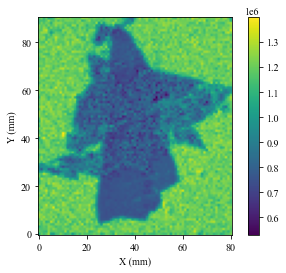

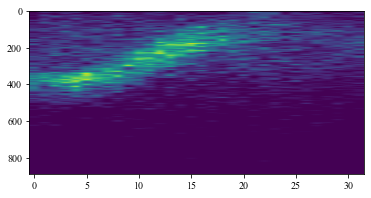

In [4]:
tot_map = np.sum(np.sum(original_mapdata, axis = 3), axis = 2)
# plot image
plt.imshow(tot_map, origin='lower')
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()

ARPES = np.array(original_mapdata)[15][40]
# plot image
fig, ax = plt.subplots()
ax.imshow(ARPES, aspect = 0.0175)
plt.show()

### - Truth Table

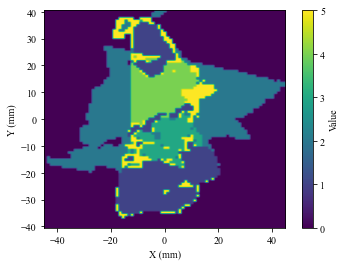

In [5]:
file_TT = h5py.File("truth_table.h5", 'r')
dataset_TT = file_TT['s2']  
TruthTable = dataset_TT[:]  
#switch BN and MoS2-Au
TruthTable = np.where(TruthTable == 2, 1, np.where(TruthTable == 1, 2, TruthTable))
#set all uncertain points to 5
non_integer_mask = (TruthTable % 1 != 0)
TruthTable = np.where(non_integer_mask, 5, TruthTable)

fig, ax = plt.subplots()
im = ax.imshow(TruthTable, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

cbar = plt.colorbar(im)
cbar.set_label('Value')
plt.show()

### - Self-defined functions for calculating performance metrics and plotting

In [6]:
#Calculate Accuracy, Precision, Recall and F1
def calculate_metrics(nk, comment, TruthTable, km_results):
    filename = "metrics_correlations.txt"
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        if comment is None:
            file.write("nk = {}".format(nk) + "\n")  # Add a new line after each output
        elif nk is None:
            file.write(comment + "\n")  # Add a new line after each output

    TruthTable = TruthTable.reshape(1, -1)
    km_results = km_results.reshape(1, -1)
    
    mask = TruthTable != 5
    TruthTable = TruthTable[mask]
    km_results = km_results[mask]

    # Overall Accuracy
    equal_elements = TruthTable == km_results
    similarity_rate = np.mean(equal_elements)
    print("Overall Accuracy: ", similarity_rate)
    output_text = "Overall Accuracy: {}".format(similarity_rate)
    with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    
    sample = ["Au", "BN", "MoS2-Au", "1-MoS2", "m-MoS2"]
    metrics_sum_list = np.zeros((1,4))
    for i in range(len(sample)):
        metrics_list = np.zeros((1,4))
        sample_TruthTable = np.where(TruthTable == i, 1, 0)
        sample_prediction = np.where(km_results == i, 1, 0)       

        TP = np.sum((sample_TruthTable == 1) & (sample_prediction == 1))
        FN = np.sum((sample_TruthTable == 1) & (sample_prediction == 0))
        FP = np.sum((sample_TruthTable == 0) & (sample_prediction == 1))
        TN = np.sum((sample_TruthTable == 0) & (sample_prediction == 0))

        if TP+FN+FP != 0:
            Accuracy = TP/(TP+FN+FP)
        else:
            Accuracy = 0

        if TP+FP != 0:
            Precision = TP/(TP+FP)
        else:
            Precision = 0

        if TP+FN != 0:
            Recall = TP/(TP+FN)
        else:
            Recall = 0

        if Precision + Recall != 0:
            F1 = 2 * Precision * Recall / (Precision + Recall)
        else:
            F1 = 0

        metrics_list[0,0] = Accuracy
        metrics_list[0,1] = Precision
        metrics_list[0,2] = Recall
        metrics_list[0,3] = F1
        metrics_sum_list = metrics_sum_list + metrics_list
        print("Accuracy, Precision, Recall and F1 of {}: ".format(sample[i]), Accuracy, Precision, Recall, F1)
        output_text = "Accuracy, Precision, Recall and F1 of {}: {}, {}, {}, {}".format(sample[i], Accuracy, Precision, Recall, F1)
        with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    marco_num = metrics_sum_list / 5
    print("marco averaging: ", marco_num[0,0], marco_num[0,1], marco_num[0,2], marco_num[0,3])
    output_text = "marco averaging: {}, {}, {}, {}".format( marco_num[0,0], marco_num[0,1], marco_num[0,2], marco_num[0,3])
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        file.write(output_text + "\n")  # Add a new line after each output

In [7]:
# Obtain the index chosen 
def get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng):
    arr = np.array(ang)
    condition = arr < ang_left
    if not np.any(condition):
        LR_col = 0
    else:
        indexes = np.where(condition)
        LR_col = indexes[0][-1]

    condition = arr > ang_right
    if not np.any(condition):
        RR_col = len(ang)-1
    else:
        indexes = np.where(condition)
        RR_col = indexes[0][0]
   
    arr = np.array(eng)
    condition = arr < eng_left
    if not np.any(condition):
        LR_row = 0
    else:
        indexes = np.where(condition)
        LR_row = indexes[0][-1]

    condition = arr > eng_right
    if not np.any(condition):
        RR_row = len(eng)-1
    else:
        indexes = np.where(condition)
        RR_row = indexes[0][0]
    
    #print("The range of angle is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(ang[LR_col],LR_col,ang[RR_col],RR_col,LR_col+1,ang[LR_col+1],RR_col-1,ang[RR_col-1]))
    #print("The range of energy is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(eng[LR_row],LR_row,eng[RR_row],RR_row,LR_row+1,eng[LR_row+1],RR_row-1,eng[RR_row-1]))
    
    return LR_col,RR_col,LR_row,RR_row

In [8]:
def correlations_plot(correlation_results):
    correlation_results = np.array(correlation_results).reshape(91, 81)
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(correlation_results.T, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower', aspect = 1)
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_title(f"{material} as the reference", fontsize=fontsize1, fontname='Times New Roman')
    cbar = plt.colorbar(im)
    plt.show()
    
    return fig

In [9]:
def clustering_plot(nk, km_results):
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)    
    for i in range(nk):
        x = []
        y = []
        for j in range(pn):
            curcln = km_results[j]
            if i == curcln:
                x = np.append(x, xpos[j])
                y = np.append(y, ypos[j])
            if j == pn-1:
                ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i], label=str(i+1))

    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
    #ax.set_title(f"{material}({posx},{posy})", loc="left", fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)  
    i = 0
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
        text.set_color(col_arr[i])
        i = i+1
    i = 0
    for handle in legend.legendHandles:
        handle.set_color(col_arr[i])  
        handle.set_sizes([600])   
        i = i+1
    plt.show()
    
    return fig

### - Only analyse the mapdata in range eng [92,96] and ang [-15,5] 
#### - These are adjustable parameters

In [10]:
LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(-15, 5, 92, 96, ang, eng)
mapdata = original_mapdata[:,:,LR_row:RR_row+1, LR_col:RR_col+1]

### - Spatial map of total ARPES intensity with the window above

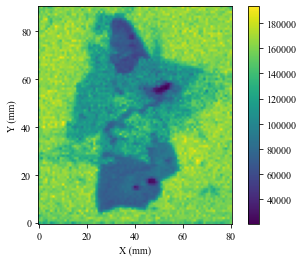

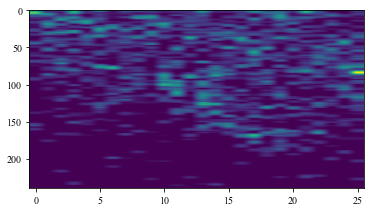

In [11]:
tot_map = np.sum(np.sum(mapdata, axis = 3), axis = 2)
# plot image
plt.imshow(tot_map, origin='lower')
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()

ARPES = np.array(mapdata)[55][40]

# plot image
fig, ax = plt.subplots()
ax.imshow(ARPES, aspect = 0.0575)
plt.show()

In [12]:
combined_correlation_results = []

## Part 1:  2D image of Au  with coordinates (10,10) as reference picture

In [13]:
material = "Au"
posx = 10
posy = 10

### - Main body and plotting

Elapsed Time:  0.3275127410888672


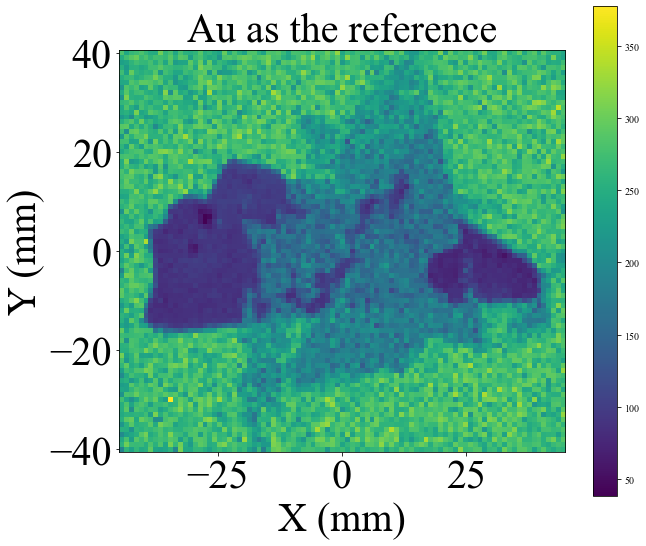

In [14]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

correlation_results = np.array(correlation_results).reshape(91, 81)
combined_correlation_results.append(correlation_results)

### - K-means clustering with the input of correlation numbers
#### - SSE curve

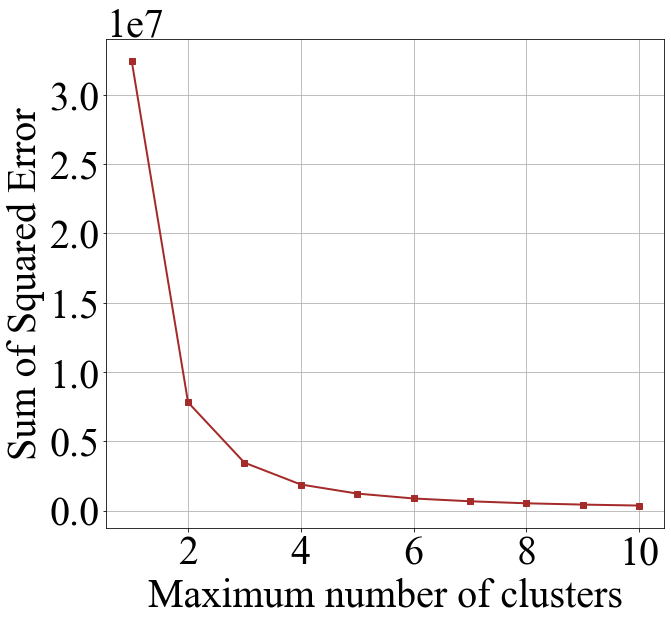

In [15]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 2

Overall Accuracy:  0.7206783525723244
Accuracy, Precision, Recall and F1 of Au:  0.8601110882534458 0.8629514963880289 0.9961877531570169 0.924795399247954
Accuracy, Precision, Recall and F1 of BN:  0.40331491712707185 0.40331491712707185 1.0 0.5748031496062993
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.25268520107610354 0.25325328270302017 0.39923755063140337 0.2999197097708507


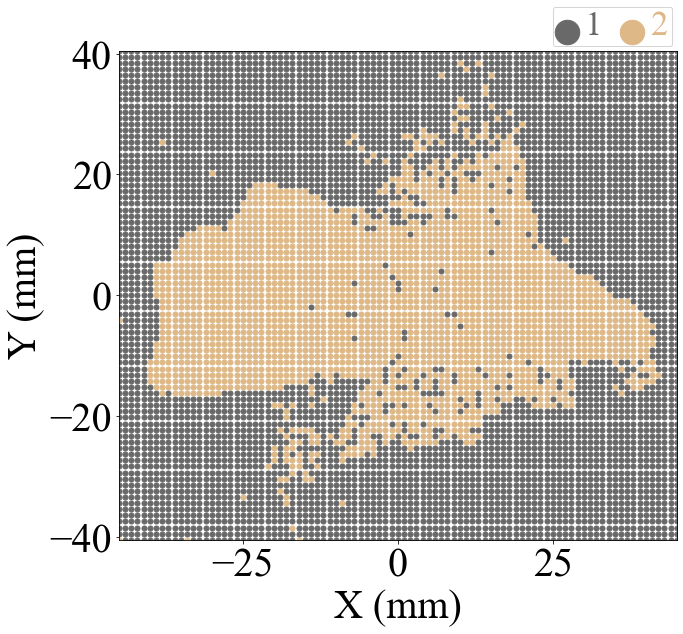

In [16]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy), TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 3

Overall Accuracy:  0.8381074533276329
Accuracy, Precision, Recall and F1 of Au:  0.8993668023518769 0.9464540694907188 0.9475816059089827 0.9470175020835814
Accuracy, Precision, Recall and F1 of BN:  0.8418467583497053 0.8578578578578578 0.978310502283105 0.9141333333333332
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.5080058224163028 0.5765418502202643 0.8103715170278638 0.6737451737451736
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.449843876623577 0.4761707555137682 0.5472527250439903 0.5069792018324176


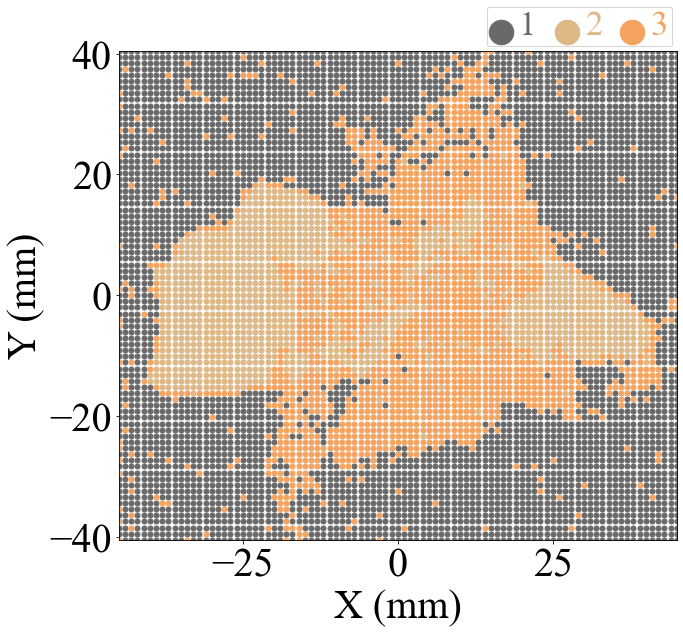

In [17]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 2: 2, 1: 1}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 4

Overall Accuracy:  0.5844377939290295
Accuracy, Precision, Recall and F1 of Au:  0.6068720379146919 0.9910990712074303 0.6101977603049797 0.7553458192007078
Accuracy, Precision, Recall and F1 of BN:  0.8822916666666667 0.9097744360902256 0.9668949771689498 0.937465412285556
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.16143497757847533 0.22554216867469878 0.3622291021671827 0.277992277992278
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.15432098765432098 0.15767344078486334 0.87890625 0.26737967914438504
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.360983933962831 0.4568178233514436 0.5636456179282223 0.4476366377245854


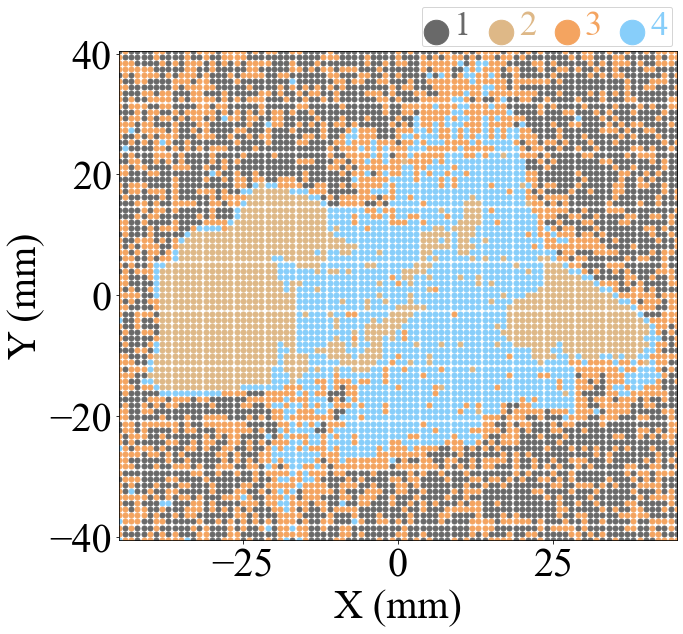

In [18]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 2: 3, 3: 0, 1:2}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 5

Overall Accuracy:  0.5347014393615506
Accuracy, Precision, Recall and F1 of Au:  0.4519516092216389 0.9149722735674677 0.47176554681915656 0.622543625216161
Accuracy, Precision, Recall and F1 of BN:  0.91894852135816 0.9577625570776256 0.9577625570776256 0.9577625570776256
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.42651469706058787 0.6546961325966851 0.5503095975232198 0.59798149705635
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.22424242424242424 0.23221757322175732 0.8671875 0.36633663366336633
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0.0 0.0 0
marco averaging:  0.40433145037656215 0.5519297072927072 0.5694050402840004 0.5089248626027005


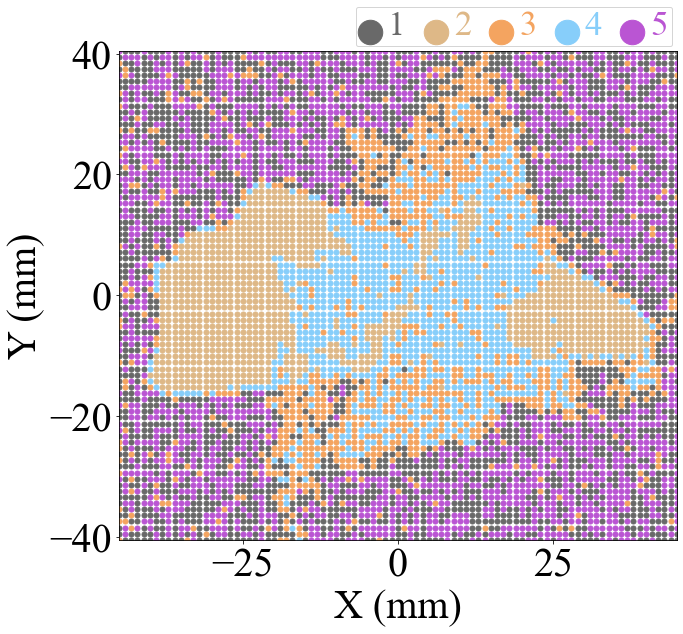

In [19]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:0, 1: 3, 2:1, 3:2, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 2: 2D image of BN  with coordinates (15,40) as reference picture

In [20]:
material = "BN"
posx = 15
posy = 40

Elapsed Time:  0.4374570846557617


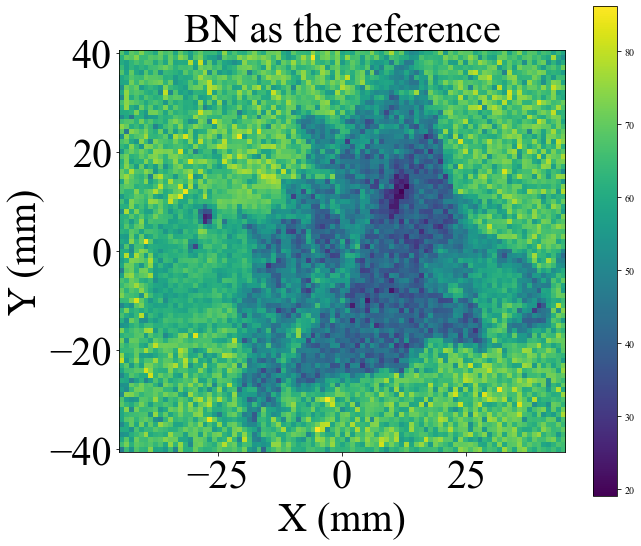

In [21]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

correlation_results = np.array(correlation_results).reshape(91, 81)
combined_correlation_results.append(correlation_results)

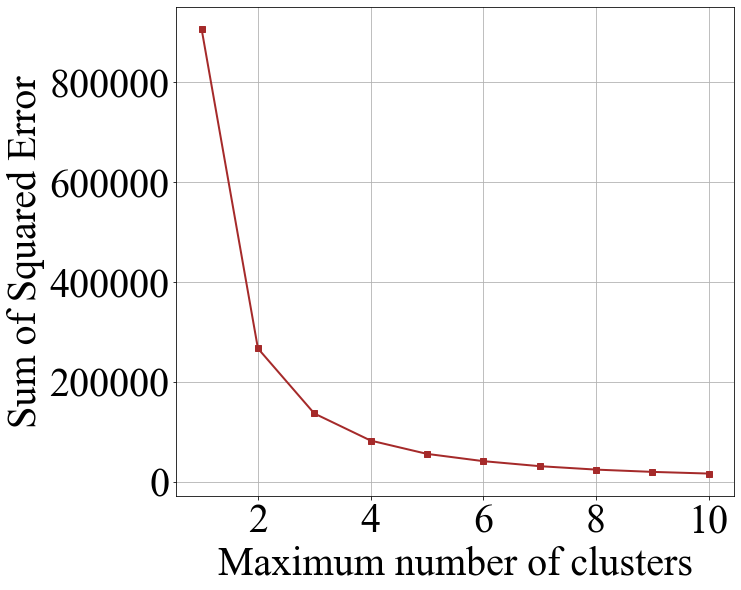

In [22]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.599258942568049
Accuracy, Precision, Recall and F1 of Au:  0.782591648696334 0.815359477124183 0.9511555873242793 0.878038051248213
Accuracy, Precision, Recall and F1 of BN:  0.07650862068965517 0.10042432814710042 0.24315068493150685 0.14214214214214213
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.17182005387719784 0.18315676105425668 0.23886125445115725 0.20403603867807102


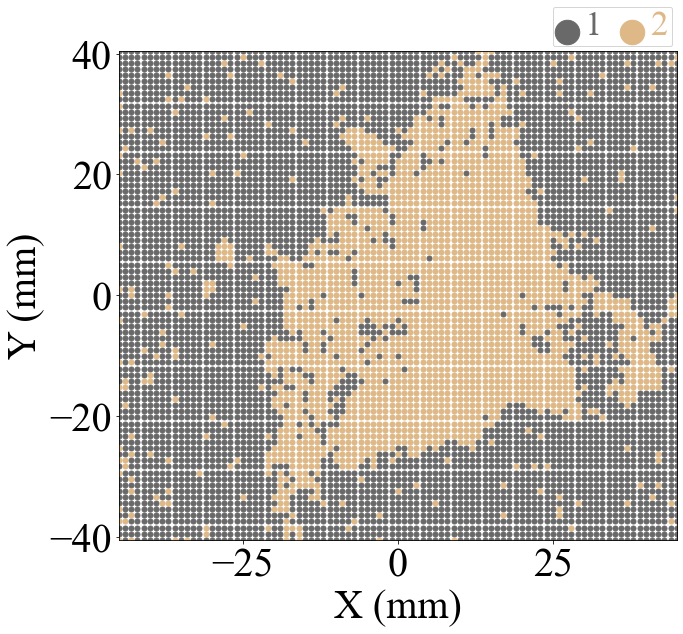

In [23]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5711842667806755
Accuracy, Precision, Recall and F1 of Au:  0.5808342728297633 0.9154228855721394 0.6137717417202764 0.734845243189274
Accuracy, Precision, Recall and F1 of BN:  0.19324324324324324 0.21536144578313254 0.6529680365296804 0.32389580973952437
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.43456291056088936 0.5559146735617324 0.6656346749226006 0.6058471292708701
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.2417280853267792 0.3373398009834009 0.3864748906345115 0.33291763643993366


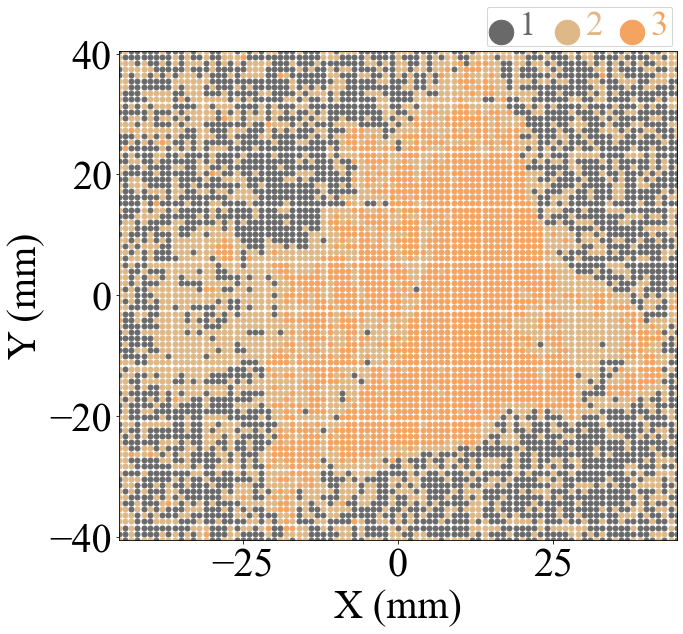

In [24]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 2, 2: 1}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.4115718968220037
Accuracy, Precision, Recall and F1 of Au:  0.40548072457036693 0.9412398921832884 0.41601143674052893 0.5769993390614673
Accuracy, Precision, Recall and F1 of BN:  0.1577574967405476 0.18086696562032886 0.5525114155251142 0.2725225225225225
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.31501416430594903 0.5403304178814383 0.43034055727554177 0.4791038345540715
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0633147113594041 0.07000686341798215 0.3984375 0.1190893169877408
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.18831341939525353 0.3464888278206076 0.359460181908237 0.2895430026251604


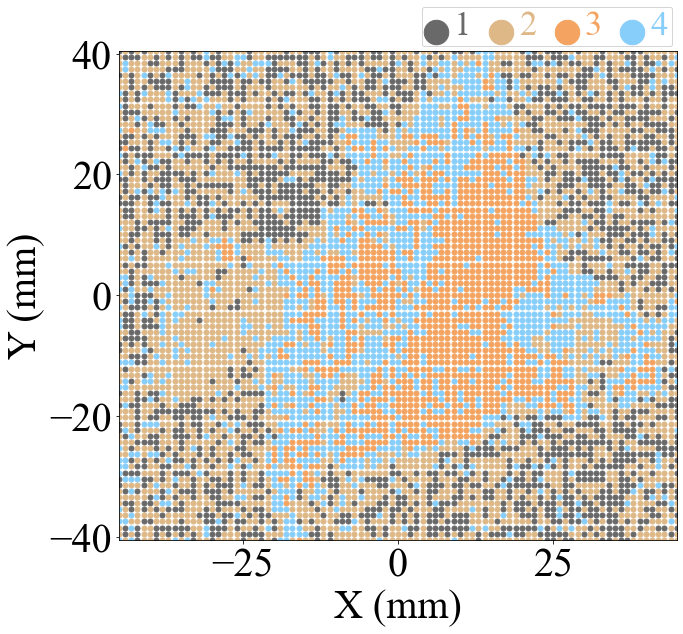

In [25]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {3: 1,1:2,2:0,0:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.30825138948268493
Accuracy, Precision, Recall and F1 of Au:  0.2978174137526402 0.9519879969992499 0.3023588277340958 0.45895117540687164
Accuracy, Precision, Recall and F1 of BN:  0.17954759660697456 0.23417332513829134 0.4349315068493151 0.3044346783859369
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.23564593301435408 0.5090439276485789 0.30495356037151705 0.3814133591481123
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.09516129032258064 0.10707803992740472 0.4609375 0.17378497790868924
Accuracy, Precision, Recall and F1 of m-MoS2:  0.00038819875776397513 0.0004585052728106373 0.0025252525252525255 0.0007760962359332556
marco averaging:  0.16171208649086272 0.360548358997267 0.3011413294960361 0.2638720574171087


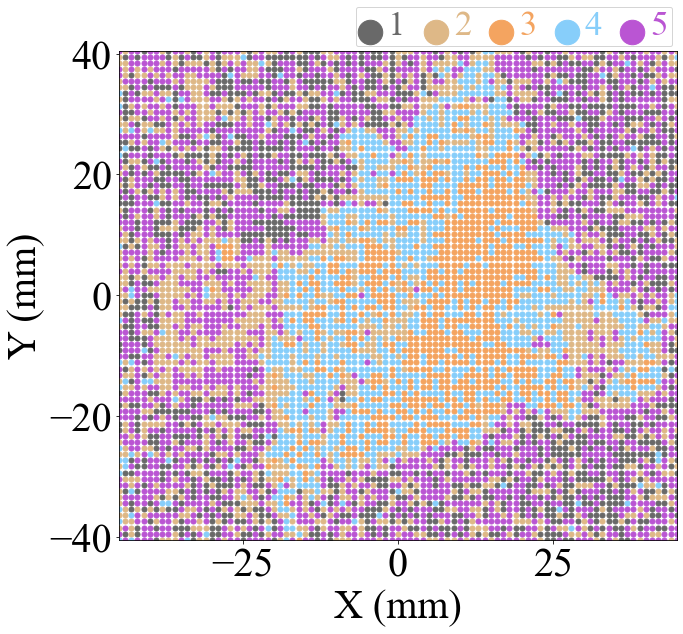

In [26]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:1,1:3,3:2,2:0,4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 3: 2D image of mono-MoS2  with coordinates (35,40) as reference picture

In [27]:
material = "1-MoS2"
posx = 35
posy = 40

Elapsed Time:  0.766688346862793


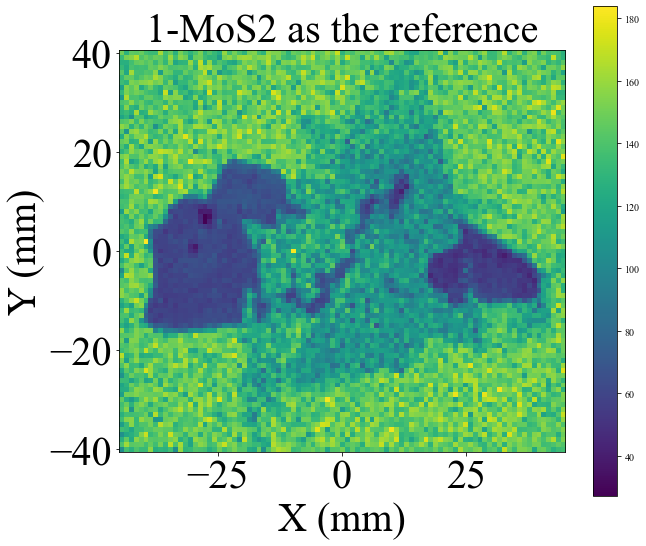

In [28]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

correlation_results = np.array(correlation_results).reshape(91, 81)
combined_correlation_results.append(correlation_results)

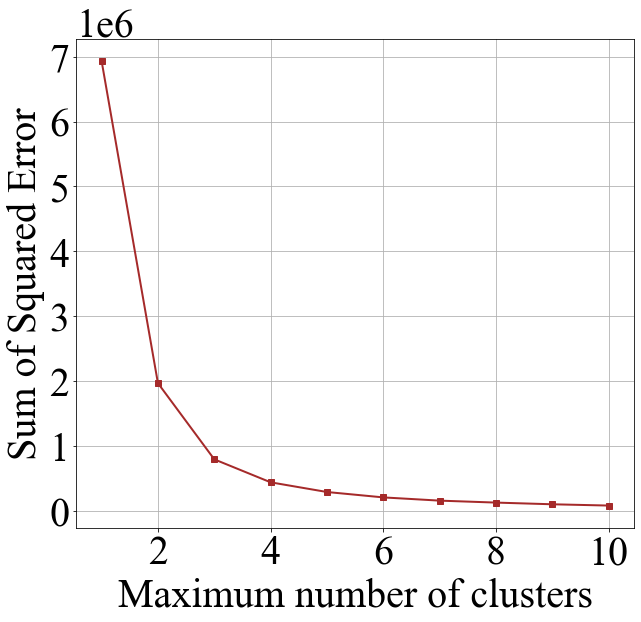

In [29]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7198232863046886
Accuracy, Precision, Recall and F1 of Au:  0.7694859038142621 0.7724750277469479 0.9949964260185847 0.8697282099343954
Accuracy, Precision, Recall and F1 of BN:  0.542803970223325 0.5431409062693979 0.9988584474885844 0.7036590269400885
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.2624579748075174 0.2631231868032692 0.3987709747014338 0.3146774473748968


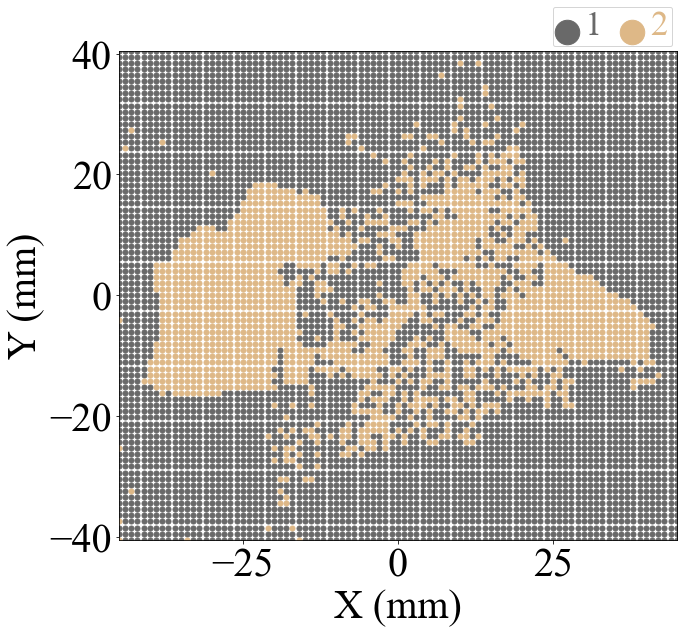

In [30]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7764001710132535
Accuracy, Precision, Recall and F1 of Au:  0.7930415263748597 0.9319440780796624 0.841791756016202 0.8845768652979469
Accuracy, Precision, Recall and F1 of BN:  0.8825331971399387 0.8934850051706308 0.9863013698630136 0.9376017362995116
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.4204 0.46525011066843736 0.8134674922600619 0.5919459307237398
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.41919494470295965 0.4581358387837461 0.5283121236278555 0.4828249064642397


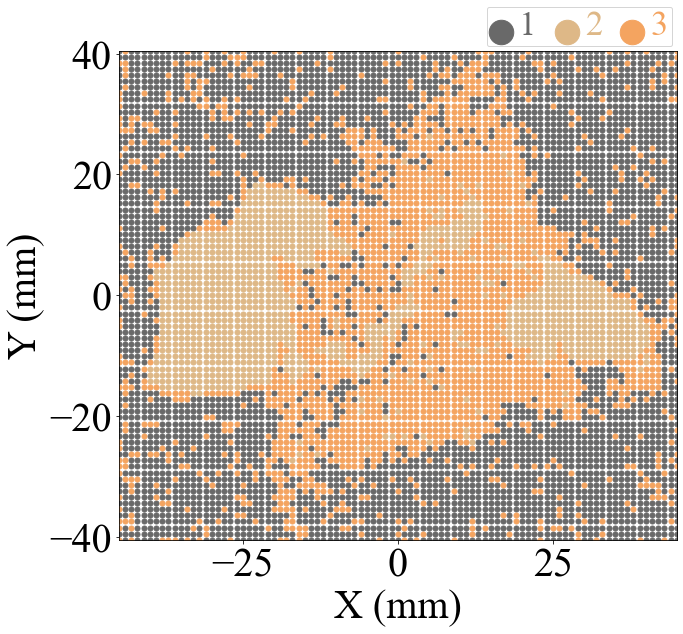

In [31]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 2, 1: 0, 2: 1}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5798774405016389
Accuracy, Precision, Recall and F1 of Au:  0.5577736026303429 0.9749589490968801 0.5658803907553014 0.7161163877581788
Accuracy, Precision, Recall and F1 of BN:  0.922077922077922 0.9466666666666667 0.9726027397260274 0.9594594594594594
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.38680257510729615 0.5576179427687549 0.5580495356037152 0.5578336557059961
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.04795877923107412 0.05067001675041876 0.47265625 0.09152798789712557
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.382922575809327 0.505982715056544 0.5138377832170088 0.46498749816415197


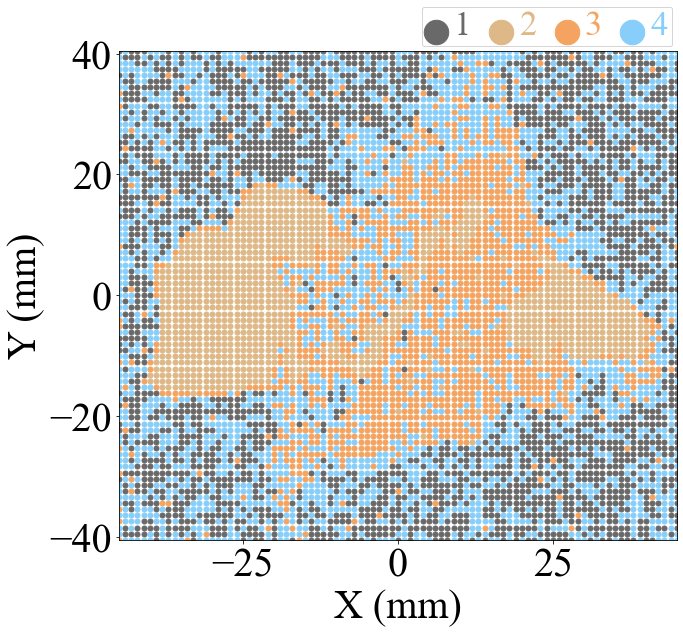

In [32]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 2, 2: 1, 3:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.48282741912498217
Accuracy, Precision, Recall and F1 of Au:  0.439891940567312 0.8885857207821737 0.465570645699309 0.6110068792995622
Accuracy, Precision, Recall and F1 of BN:  0.9226519337016574 0.9664351851851852 0.9531963470319634 0.9597701149425288
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.28031687995124926 0.5686032138442522 0.3560371517027864 0.43788672060923367
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.08466257668711656 0.09126984126984126 0.5390625 0.15610859728506787
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0004930966469428008 0.000612369871402327 0.0025252525252525255 0.0009857072449482502
marco averaging:  0.3456032855108556 0.5031012661905709 0.46327837939186234 0.43315160387626817


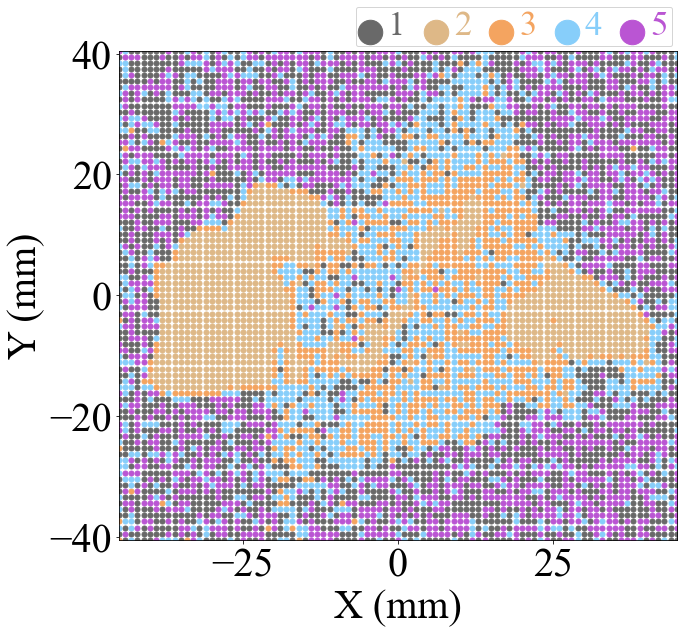

In [33]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 1, 2: 2, 3:3, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 4: 2D image of multi-MoS2  with coordinates (55,40) as reference picture

In [34]:
material = "m-MoS2"
posx = 55
posy = 40

Elapsed Time:  0.7520251274108887


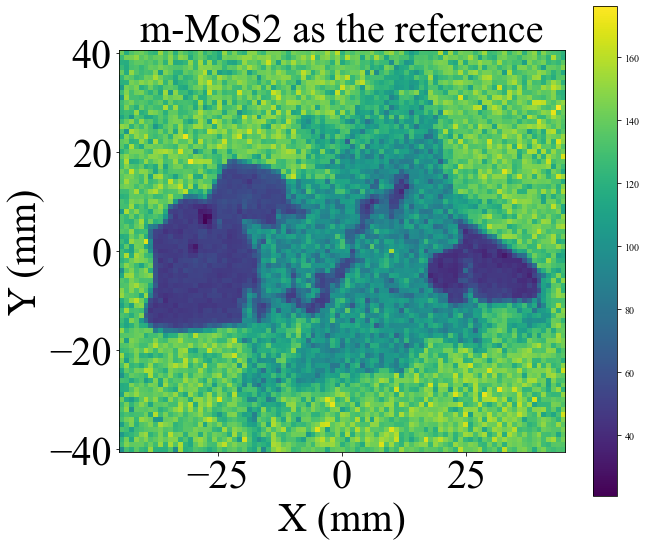

In [35]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time) 

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

correlation_results = np.array(correlation_results).reshape(91, 81)
combined_correlation_results.append(correlation_results)

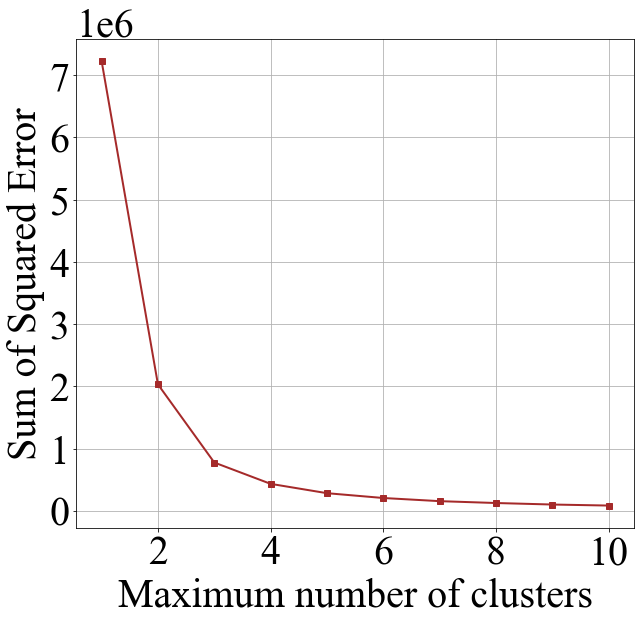

In [36]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7206783525723244
Accuracy, Precision, Recall and F1 of Au:  0.789463746223565 0.7918560606060606 0.9961877531570169 0.882346734198586
Accuracy, Precision, Recall and F1 of BN:  0.5043177892918825 0.5043177892918825 1.0 0.6704936854190586
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.2587563071030895 0.2592347699795886 0.39923755063140337 0.3105680839235289


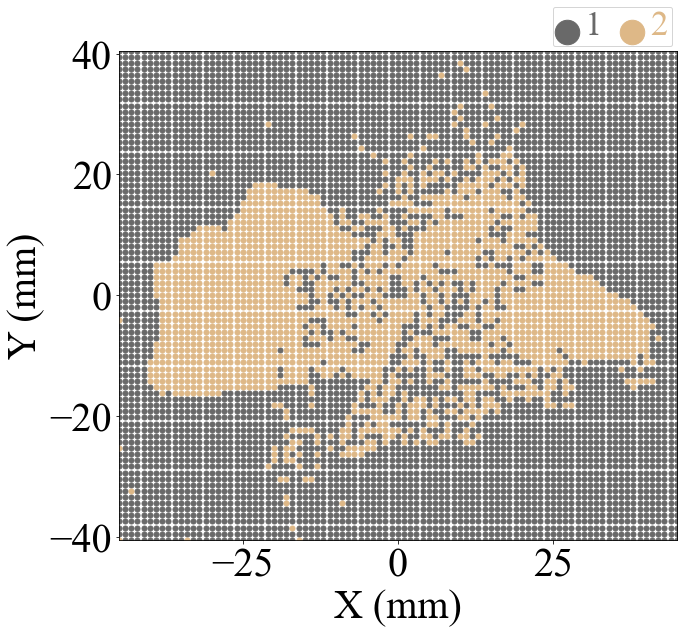

In [37]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.8030497363545674
Accuracy, Precision, Recall and F1 of Au:  0.8396120009023235 0.9403739262253663 0.8868239218489398 0.9128142244022073
Accuracy, Precision, Recall and F1 of BN:  0.9055613850996852 0.9180851063829787 0.9851598173515982 0.9504405286343612
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.44472681067344344 0.49551675318546484 0.8126934984520123 0.6156552330694811
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.43798003933509044 0.47079515715876197 0.53693544753051 0.49578199722120997


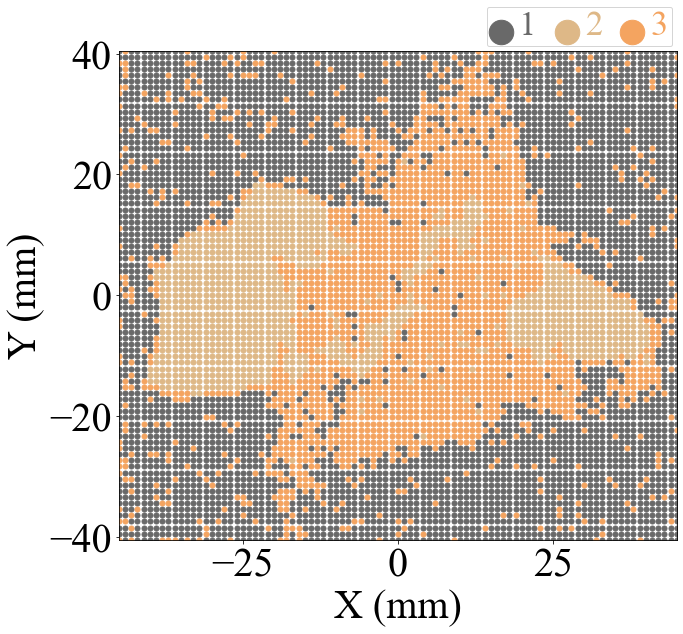

In [38]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1: 1, 2: 2, 0: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5888556363118141
Accuracy, Precision, Recall and F1 of Au:  0.5988221436984688 0.9814671814671815 0.6056707171789374 0.7490791218505969
Accuracy, Precision, Recall and F1 of BN:  0.9291938997821351 0.9530726256983241 0.973744292237443 0.9632975719932242
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.17787491593813046 0.2392582541836273 0.40944272445820434 0.3020268341421639
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.15193571950328708 0.15745647236941712 0.8125 0.2637920101458465
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.3715653357844043 0.46625090674371006 0.5602715467749169 0.4556391076263663


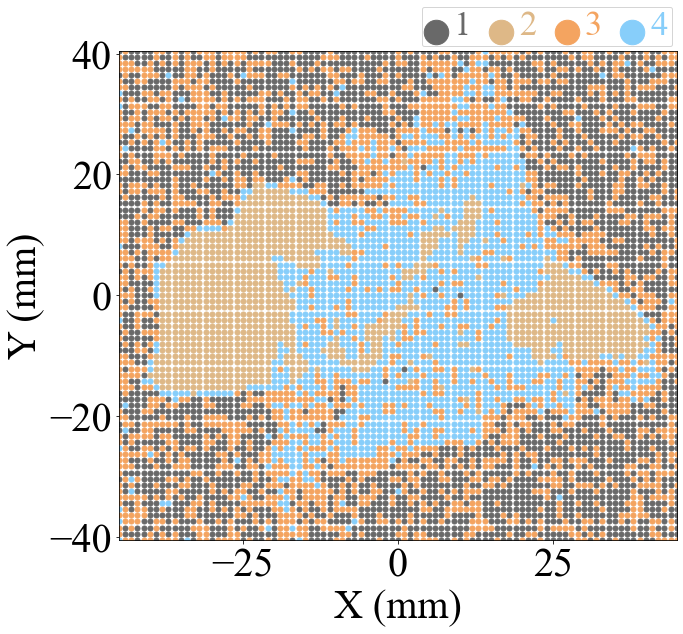

In [39]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1:1,3:3,0:0,2:2}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.4882428388200086
Accuracy, Precision, Recall and F1 of Au:  0.42015209125475284 0.9938167509836987 0.4212532761496307 0.5917001338688086
Accuracy, Precision, Recall and F1 of BN:  0.9324473975636767 0.9689298043728424 0.9611872146118722 0.9650429799426935
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.3311491935483871 0.4870274277242402 0.5085139318885449 0.497538811056418
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.15783898305084745 0.17801672640382318 0.58203125 0.27264409881061297
Accuracy, Precision, Recall and F1 of m-MoS2:  0.003892565200467108 0.004580852038479157 0.025252525252525252 0.007754943776657619
marco averaging:  0.36909604612362623 0.5264743123046167 0.49964763958051456 0.46693619349103815


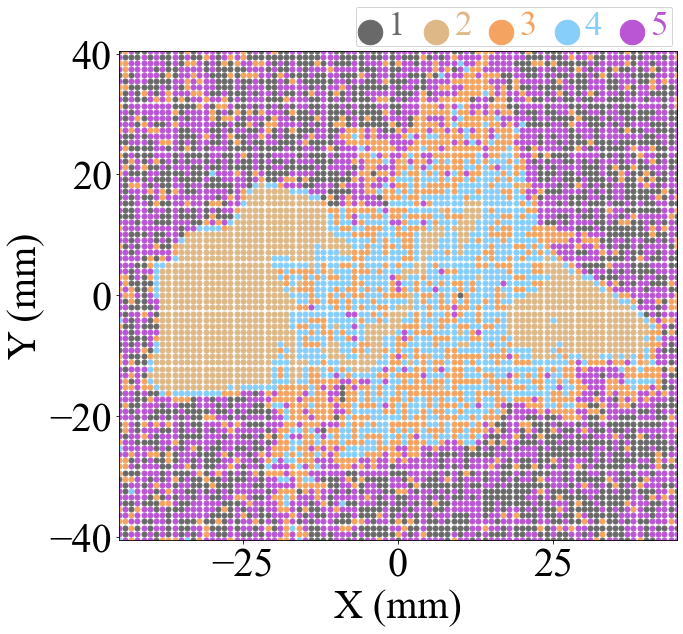

In [40]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1:1, 3:3, 0:2, 2:0, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 5: 2D image of mono-MoS2  with Fig4o(ii) in the paper as reference picture

In [41]:
material = "standard 1-MoS2"

In [42]:
reference_monoMoS2 = np.load("reference_1600_field3_target1_nk4_2.npy")

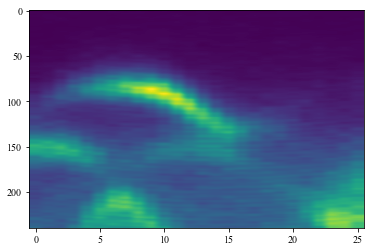

In [43]:
plt.imshow(reference_monoMoS2, aspect="auto")
reference_monoMoS2 = reference_monoMoS2[232:472,1:27]
plt.imshow(reference_monoMoS2, aspect="auto")

Elapsed Time:  0.9650473594665527


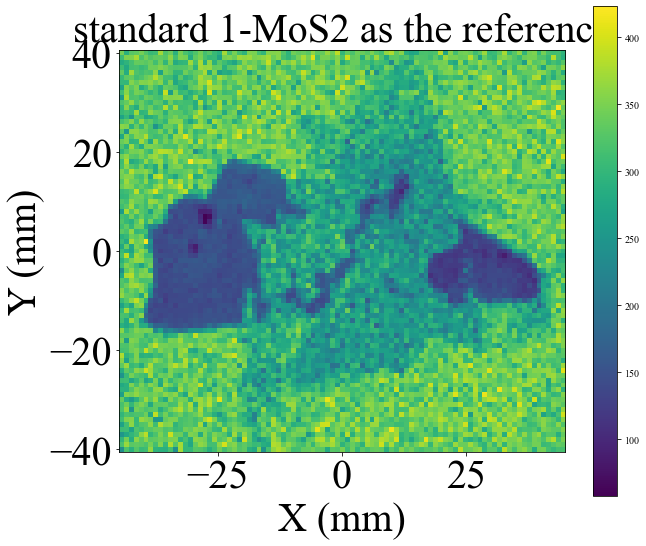

In [44]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        mapdata[i,j] = np.flip(mapdata[i,j])
        correlation_result = signal.correlate2d(np.divide(reference_monoMoS2,np.max(reference_monoMoS2)), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_reference.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_reference.svg', dpi=300, bbox_inches='tight')

correlation_results = np.array(correlation_results).reshape(91, 81)
combined_correlation_results.append(correlation_results)

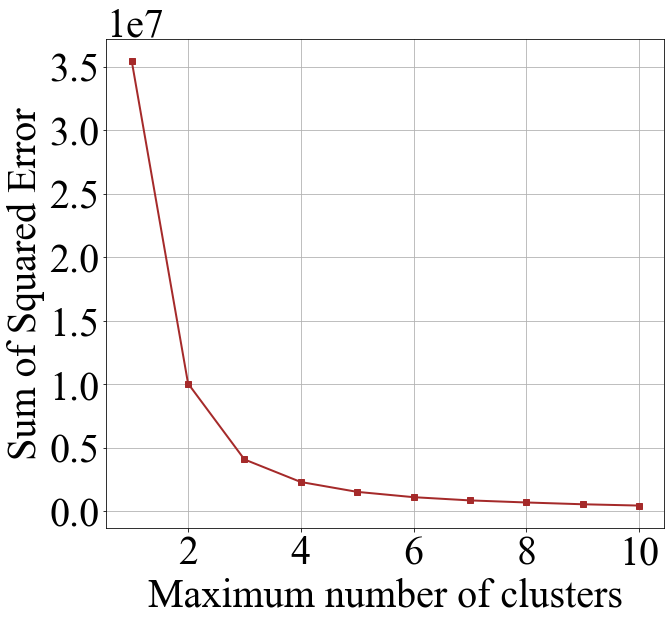

In [45]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_reference.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_reference.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7196807752600827
Accuracy, Precision, Recall and F1 of Au:  0.7628357390827699 0.765914511098881 0.9947581605908983 0.8654643449419569
Accuracy, Precision, Recall and F1 of BN:  0.5583918315252074 0.5587484035759898 0.9988584474885844 0.7166257166257166
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.26424551412159547 0.2649325829349741 0.3987233216158965 0.3164180123135347


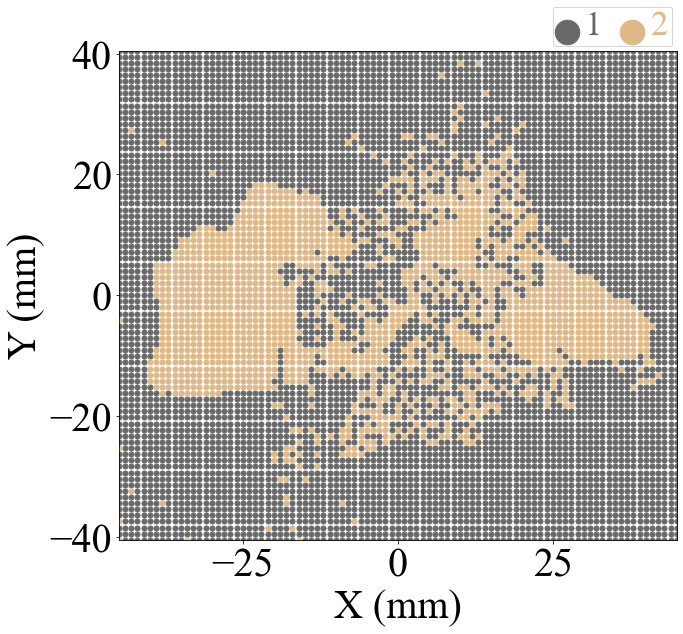

In [46]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7668519310246544
Accuracy, Precision, Recall and F1 of Au:  0.781941309255079 0.9369759264268326 0.8253514415058375 0.8776285786673422
Accuracy, Precision, Recall and F1 of BN:  0.8634097706879362 0.8721047331319235 0.9885844748858448 0.9266987693953987
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.4092679127725857 0.451654490760636 0.8134674922600619 0.5808234318872616
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.41092379854312017 0.4521470300638784 0.5254806817303488 0.47703015599000054


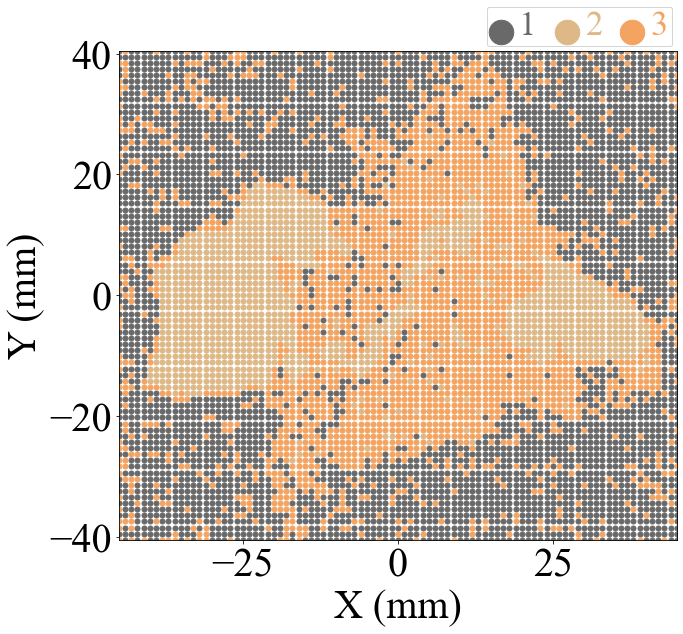

In [47]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1: 1, 0: 2, 2: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5747470428958245
Accuracy, Precision, Recall and F1 of Au:  0.5491302303714152 0.9761805265357292 0.5565880390755301 0.7089529590288316
Accuracy, Precision, Recall and F1 of BN:  0.915948275862069 0.9423503325942351 0.9703196347031964 0.9561304836895388
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.3881856540084388 0.5492537313432836 0.5696594427244582 0.5592705167173253
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.043925603482390184 0.04659949622166247 0.43359375 0.08415466262319939
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.37943795274486264 0.502876817338982 0.506032173300637 0.46170172441177904


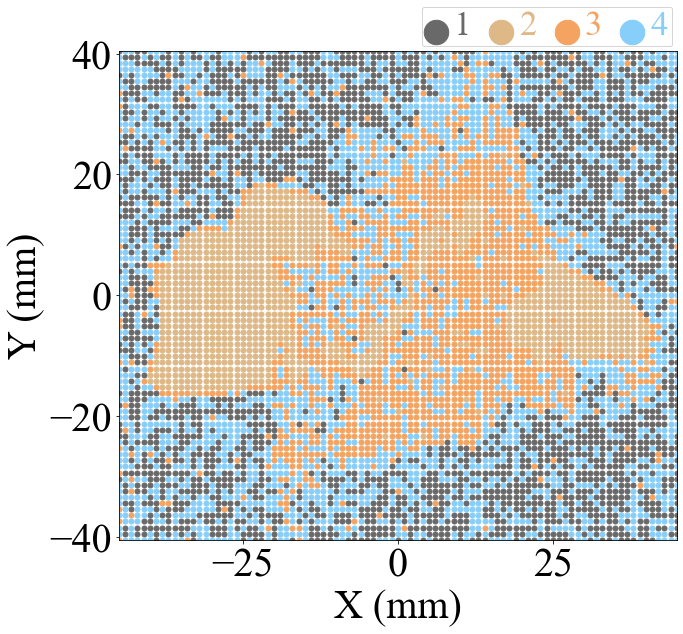

In [48]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 3: 2, 1: 3, 2:0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.4644434943708137
Accuracy, Precision, Recall and F1 of Au:  0.42758620689655175 0.8657657657657658 0.4579461520133429 0.5990338164251209
Accuracy, Precision, Recall and F1 of BN:  0.9172185430463576 0.9651567944250871 0.9486301369863014 0.9568221070811743
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.22546583850931676 0.5330396475770925 0.28095975232198145 0.3679675620881906
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.09114249037227215 0.09833795013850416 0.5546875 0.16705882352941176
Accuracy, Precision, Recall and F1 of m-MoS2:  0.00045330915684496827 0.0005521811154058532 0.0025252525252525255 0.0009062075215224288
marco averaging:  0.33237327759626867 0.4925704678043711 0.4489497587693757 0.418357703329084


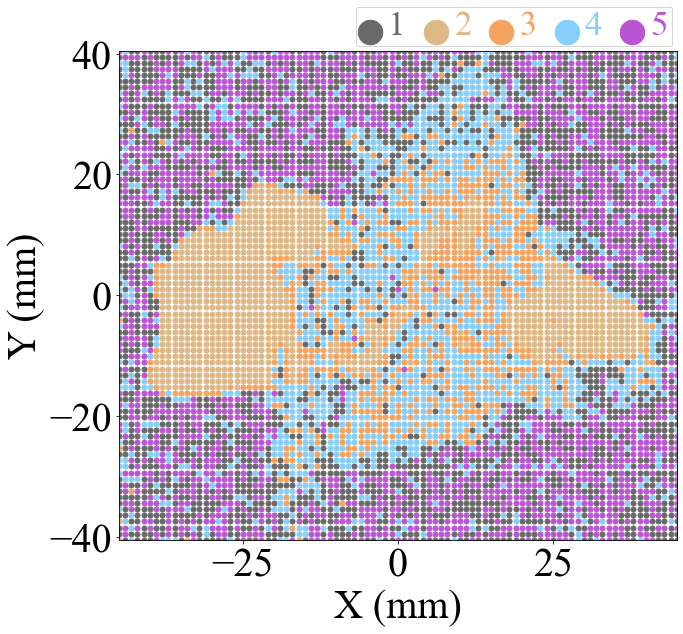

In [49]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {4:1, 2:4, 0:0, 1:2, 3:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

In [50]:
#print(combined_correlation_results[4][0][0])
targetMap = np.array(combined_correlation_results).reshape(5, 91*81).T
#print(targetMap)

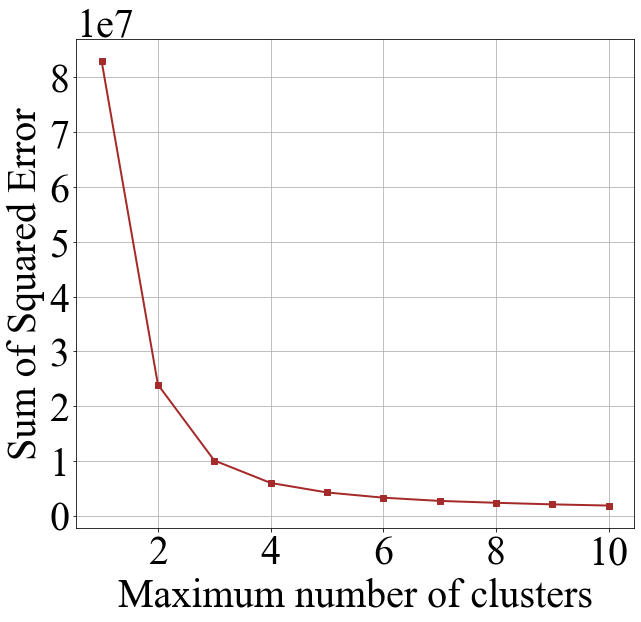

In [51]:
max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_combined.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_combined.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7191107310816588
Accuracy, Precision, Recall and F1 of Au:  0.8189316575019638 0.8232971372161896 0.993566833452466 0.9004534657741309
Accuracy, Precision, Recall and F1 of BN:  0.4487704918032787 0.4487704918032787 1.0 0.6195190947666196
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.2535404298610485 0.25441352580389365 0.39871336669049323 0.3039945121081501


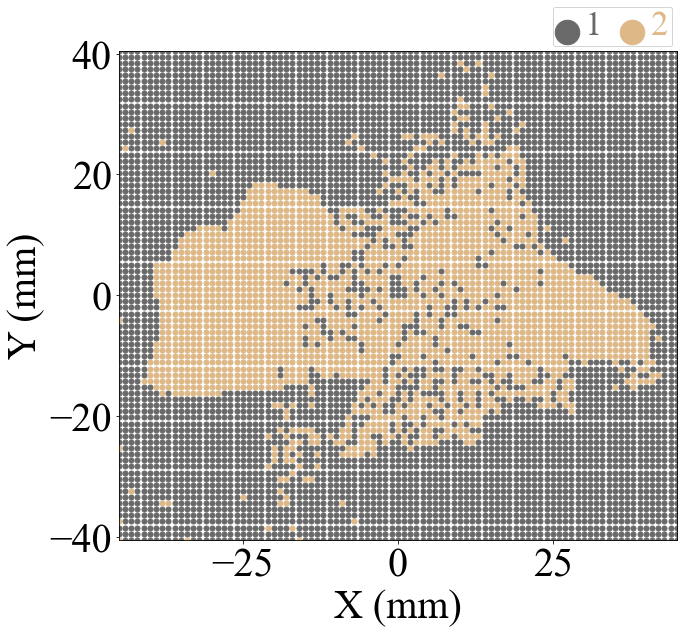

In [52]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:1, 1:0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, combined reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.8116003990309248
Accuracy, Precision, Recall and F1 of Au:  0.8544961590600995 0.9429070057342309 0.9011198475101263 0.9215399610136452
Accuracy, Precision, Recall and F1 of BN:  0.8890030832476875 0.8991683991683992 0.9874429223744292 0.941240478781284
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.458041958041958 0.512720156555773 0.8111455108359134 0.6282973621103117
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.0 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.440308240069949 0.47095911229168064 0.5399416561440937 0.4982155603810482


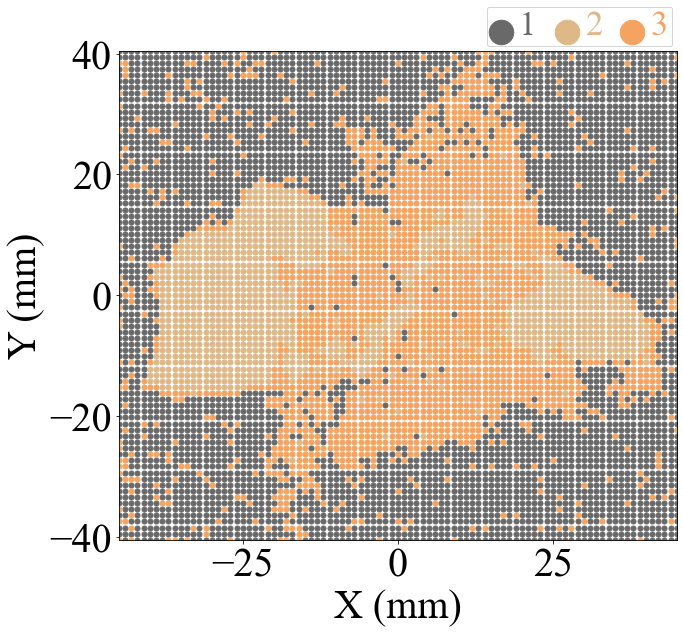

In [53]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
#label_mapping = {0:1, 1:0, 2:2}
#km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, combined reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5848653270628473
Accuracy, Precision, Recall and F1 of Au:  0.5805154882951052 0.9871330920788098 0.5849416249702168 0.7345900658288451
Accuracy, Precision, Recall and F1 of BN:  0.916219119226638 0.9394273127753304 0.973744292237443 0.9562780269058296
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.39206594538897477 0.5397163120567375 0.5890092879256966 0.5632864544781643
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.014385532264693794 0.015822784810126583 0.13671875 0.028363047001620748
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0 0 0.0 0
marco averaging:  0.38063721703508235 0.4964199003442009 0.45688279102667123 0.456503518842892


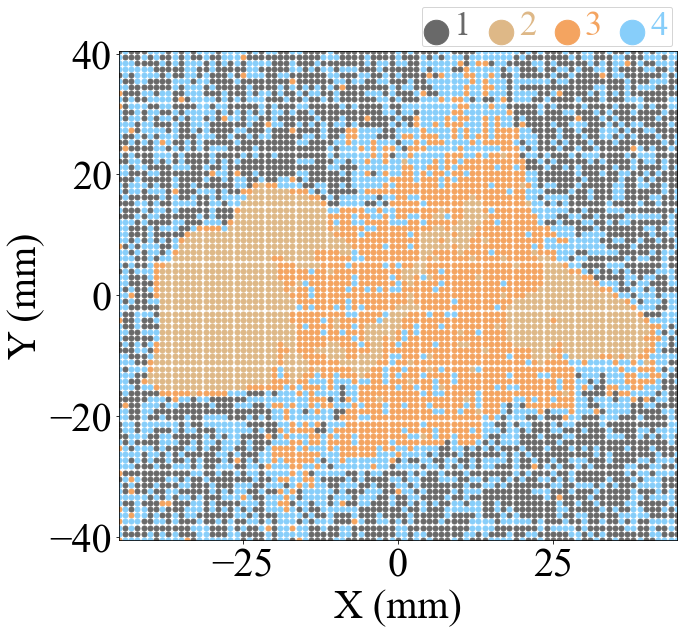

In [54]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:2, 1:0, 2:1, 3:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, combined reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.46501353854923755
Accuracy, Precision, Recall and F1 of Au:  0.451329534662868 0.9921711899791231 0.45294257803192756 0.6219532144609848
Accuracy, Precision, Recall and F1 of BN:  0.9292817679558011 0.9666666666666667 0.9600456621004566 0.9633447880870561
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.2256169212690952 0.4836272040302267 0.29721362229102166 0.36816874400767025
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.09475951184493898 0.10401891252955082 0.515625 0.17311475409836063
Accuracy, Precision, Recall and F1 of m-MoS2:  0.0019538882375928096 0.0023062730627306273 0.012626262626262626 0.0039001560062402497
marco averaging:  0.3405883247940592 0.5097580492536596 0.4476906250099336 0.4260963313320624


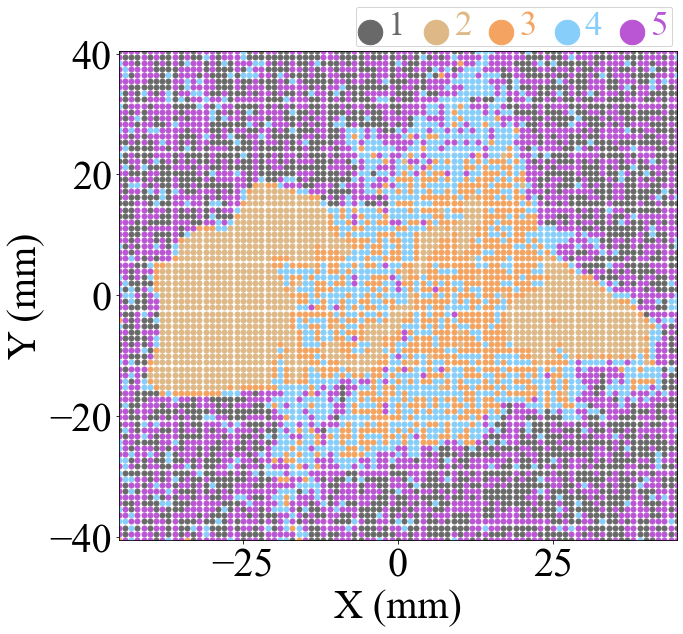

In [55]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:2, 1:0, 2:1, 3:3, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, combined reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_combined_nk{nk}.svg', dpi=300, bbox_inches='tight')